<a href="https://colab.research.google.com/github/YahyaAlaaMassoud/learn-search-relevance/blob/main/quora_semantic_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

Creating requirments.txt file and writing the needed dependencies, then installing them.

In [2]:
%%writefile requirments.txt
datasets

Overwriting requirments.txt


In [ ]:
!echo "Requirments Are:" && cat requirments.txt && echo "-----"

!pip install -r requirments.txt

In [3]:
import numpy as np

from pprint import pprint

Use hf/datasets library to import the quora datasets

In [4]:
from datasets import load_dataset_builder

load_dataset_builder can help quickly get some general info about the dataset (e.g. features, description, size)

In [5]:
ds_builder = load_dataset_builder('quora') # retruns a parquet file
ds_builder

In [6]:
pprint(ds_builder.info)

DatasetInfo(description='The Quora dataset is composed of question pairs, and '
                        'the task is to determine if the questions are '
                        'paraphrases of each other (have the same meaning).',
            citation='',
            homepage='https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs',
            license='',
            features={'is_duplicate': Value(dtype='bool', id=None),
                      'questions': Sequence(feature={'id': Value(dtype='int32',
                                                                 id=None),
                                                     'text': Value(dtype='string',
                                                                   id=None)},
                                            length=-1,
                                            id=None)},
            post_processed=None,
            supervised_keys=None,
            task_templates=None,
            builder_name=

In [6]:
from datasets import get_dataset_config_names

'config_names', get_dataset_config_names('quora')

('config_names', ['default'])

In [7]:
from datasets import get_dataset_split_names

'split_names', get_dataset_split_names('quora')

('split_names', ['train'])

In [53]:
split_range = '[0:100]'
split = 'train{}'.format(split_range)
'split', split

('split', 'train[0:100]')

In [54]:
from datasets import load_dataset

quora_ds = load_dataset(path='quora', split=split)
quora_ds

Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 100
})

In [55]:
pprint(quora_ds[0]); pprint(quora_ds[-1]);

{'is_duplicate': False,
 'questions': {'id': [1, 2],
               'text': ['What is the step by step guide to invest in share '
                        'market in india?',
                        'What is the step by step guide to invest in share '
                        'market?']}}
{'is_duplicate': False,
 'questions': {'id': [199, 200],
               'text': ['Why is the number for Skype at 1-855-425-3768 always '
                        'busy?',
                        'How could I get Skype to work on an android 4.1.1 '
                        'phone?']}}


In [56]:
pprint(quora_ds['questions'][0]['text'])

['What is the step by step guide to invest in share market in india?',
 'What is the step by step guide to invest in share market?']


In [57]:
pprint(quora_ds[:3])

{'is_duplicate': [False, False, False],
 'questions': [{'id': [1, 2],
                'text': ['What is the step by step guide to invest in share '
                         'market in india?',
                         'What is the step by step guide to invest in share '
                         'market?']},
               {'id': [3, 4],
                'text': ['What is the story of Kohinoor (Koh-i-Noor) Diamond?',
                         'What would happen if the Indian government stole the '
                         'Kohinoor (Koh-i-Noor) diamond back?']},
               {'id': [5, 6],
                'text': ['How can I increase the speed of my internet '
                         'connection while using a VPN?',
                         'How can Internet speed be increased by hacking '
                         'through DNS?']}]}


Compare two types of indexing

In [58]:
import time

start_time = time.time()
pprint(quora_ds[0]['questions']['text'])
print('elapsed time: {}'.format(time.time() - start_time))

start_time = time.time()
pprint(quora_ds['questions'][0]['text'])
print('elapsed time: {}'.format(time.time() - start_time))

['What is the step by step guide to invest in share market in india?',
 'What is the step by step guide to invest in share market?']
elapsed time: 0.003902912139892578
['What is the step by step guide to invest in share market in india?',
 'What is the step by step guide to invest in share market?']
elapsed time: 0.0019087791442871094


A function that gathers all unique questions in a list

In [59]:
def get_questions(ds):
  questions = ds['questions']
  questions_text = set()
  for q in questions:
    for q_text in q['text']:
      questions_text.add(q_text)
  unique_questions = list(questions_text)
  return [{'question': q} for q in unique_questions]

quora_questions = get_questions(ds=quora_ds)
pprint(quora_questions[:5])
'number of questions', len(quora_questions)

[{'question': 'National Institute of Technology Karnataka (NITK) , Surathkal: '
              'To the graduating batch: What lessons would you want to give to '
              'your juniors before you leave?'},
 {'question': 'How do sports contribute to the society?'},
 {'question': 'What is best way to ask for money online?'},
 {'question': 'Why do I always get depressed in the evening?'},
 {'question': 'How one should know that he/she completely prepare for CA final '
              'exam?'}]


('number of questions', 200)

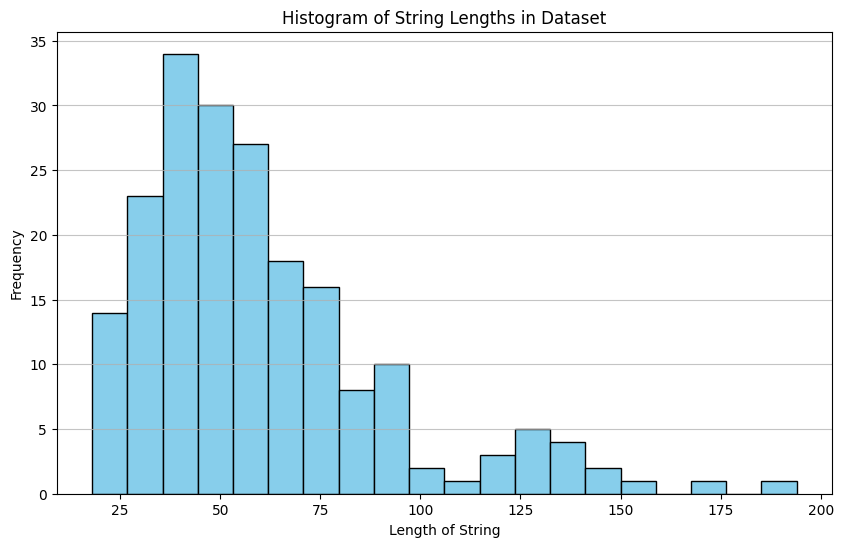

In [60]:
import matplotlib.pyplot as plt

q_length = []
for q in quora_questions:
    q_length.append(len(q['question']))

# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set figure size
plt.hist(q_length, bins=20, color='skyblue', edgecolor='black')  # Plot histogram
plt.title('Histogram of String Lengths in Dataset')
plt.xlabel('Length of String')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [31]:
%%writefile -a requirments.txt
sentence-transformers
transformers

Appending to requirments.txt


In [32]:
!echo "Requirments Are:" && cat requirments.txt && echo "-----"

!pip install -r requirments.txt

Requirments Are:
datasets
gradio
qdrant-client
sentence-transformers
transformers
-----


In [61]:
from sentence_transformers import SentenceTransformer

EMBEDDING_MODEL_NAME = 'all-MiniLM-L12-v2'

encoder = SentenceTransformer(model_name_or_path=EMBEDDING_MODEL_NAME)
encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [19]:
pprint({
    'max_seq_length': encoder.get_max_seq_length(),
    'sentence_embedding_dimension': encoder.get_sentence_embedding_dimension(),
    'tokenizer': encoder.tokenizer
})

{'max_seq_length': 128,
 'sentence_embedding_dimension': 384,
 'tokenizer': BertTokenizerFast(name_or_path='sentence-transformers/all-MiniLM-L12-v2', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}}


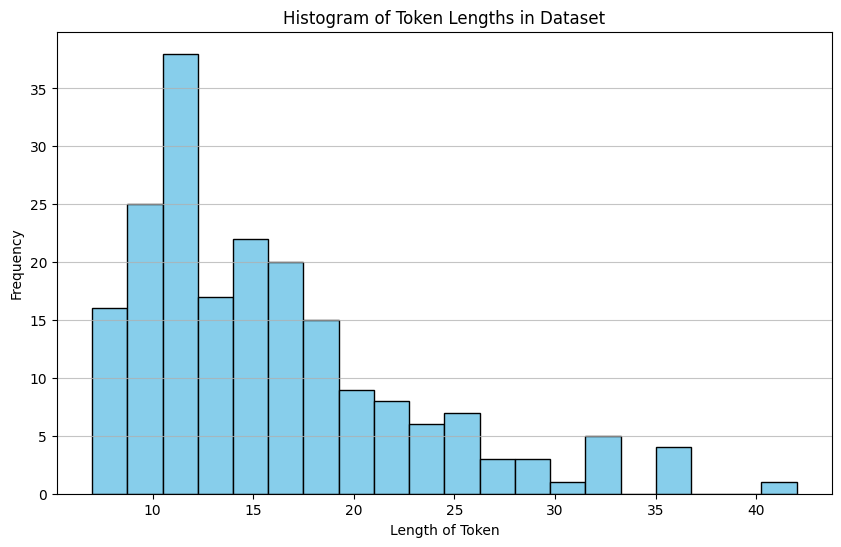

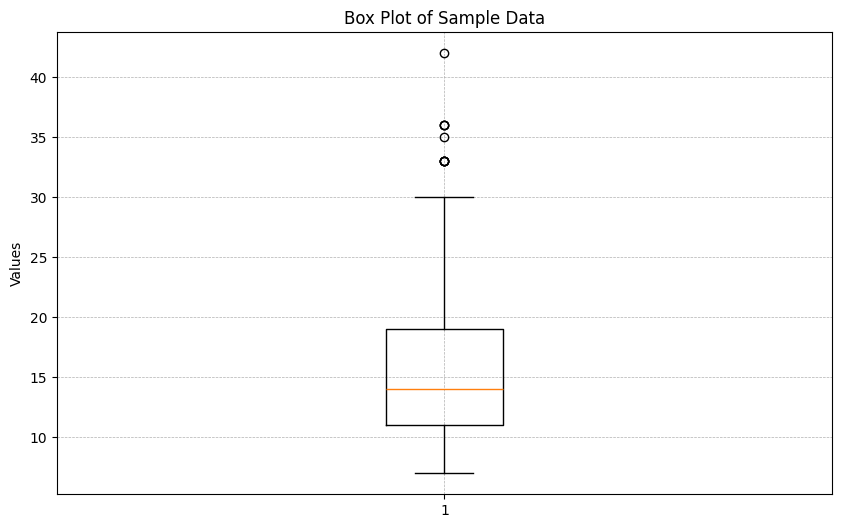

In [62]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')

sample_q = [q['question'] for q in quora_questions]

encoded_input = tokenizer(sample_q, padding=False, truncation=False)

all_tokens = encoded_input['input_ids']

token_lengths = [len(token) for token in all_tokens]

# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set figure size
plt.hist(token_lengths, bins=20, color='skyblue', edgecolor='black')  # Plot histogram
plt.title('Histogram of Token Lengths in Dataset')
plt.xlabel('Length of Token')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Creating the box plot
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the figure
plt.boxplot(token_lengths)
plt.title('Box Plot of Sample Data')
plt.ylabel('Values')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [63]:
pprint(quora_questions[0]['question'])

('National Institute of Technology Karnataka (NITK) , Surathkal: To the '
 'graduating batch: What lessons would you want to give to your juniors before '
 'you leave?')


In [64]:
def compute_embedding(sentences, emb_model):
  return emb_model.encode(sentences=sentences)

In [65]:
embedding = compute_embedding(sentences=quora_questions[0]['question'], emb_model=encoder)
assert embedding.shape[0] == encoder.get_sentence_embedding_dimension()
embedding.shape, np.min(embedding), np.max(embedding), np.mean(embedding)

((384,), -0.14915588, 0.14835277, 7.426436e-05)

In [24]:
%%writefile -a requirments.txt
qdrant-client

Appending to requirments.txt


In [ ]:
!echo "Requirments Are:" && cat requirments.txt && echo "-----"

!pip install -r requirments.txt

In [66]:
from qdrant_client import QdrantClient, models

qdrant = QdrantClient(':memory:') # create in-mem instance of vector db

In [67]:
qdrant.recreate_collection(
    collection_name='questions',
    vectors_config=models.VectorParams(
        size=encoder.get_sentence_embedding_dimension(),
        distance=models.Distance.COSINE
    )
)

True

In [68]:
qdrant.upload_records(
    collection_name='questions',
    records=[
        models.Record(
            id=idx,
            payload=entry,
            vector=compute_embedding(entry['question'], encoder).tolist()
        ) for idx, entry in enumerate(quora_questions)
    ]
)

In [69]:
def query(question, top_k=5):
  results = qdrant.search(
    collection_name='questions',
    query_vector=compute_embedding(question, encoder),
    limit=top_k
  ) # search for top 5 questions in the quora questions DB similar to the new question
  return results

In [70]:
results = query('obama', top_k=5)

for result in results:
  print('score', result.score, result.payload)

score 0.43400338292121887 {'question': 'Why do some people think Obama will try to take their guns away?'}
score 0.26785704493522644 {'question': 'How will a Trump presidency affect the students presently in US or planning to study in US?'}
score 0.2425844967365265 {'question': 'What would a Trump presidency mean for current international master’s students on an F1 visa?'}
score 0.23756226897239685 {'question': 'Who is israil friend?'}
score 0.21749085187911987 {'question': 'Where do I find a U.S. family office database?'}
